## Multi-label classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
# Data preparation steps if you are using Crestle:

# os.makedirs('data/planet/models', exist_ok=True)
# os.makedirs('/cache/planet/tmp', exist_ok=True)

# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train-jpg {PATH}
# !ln -s /datasets/kaggle/planet-understanding-the-amazon-from-space/train_v2.csv {PATH}
# !ln -s /cache/planet/tmp {PATH}

In [5]:
ls {PATH}

models/    test-jpg.tar     tmp/        train-jpg.tar     train_v2.csv
test-jpg/  test-jpg.tar.7z  train-jpg/  train-jpg.tar.7z  train_v2.csv.zip


## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

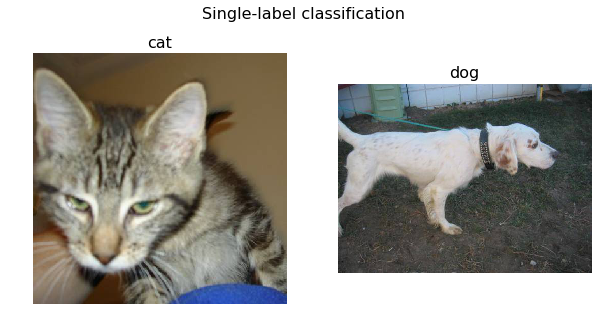

In [8]:
dc_path = "data/dogscats/valid/"
list_paths = [get_1st(f"{dc_path}cats"), get_1st(f"{dc_path}dogs")]
plots_from_files(list_paths, titles=["cat", "dog"], maintitle="Single-label classification")

In single-label classification each sample belongs to one class. In the previous example, each image is either a *dog* or a *cat*.

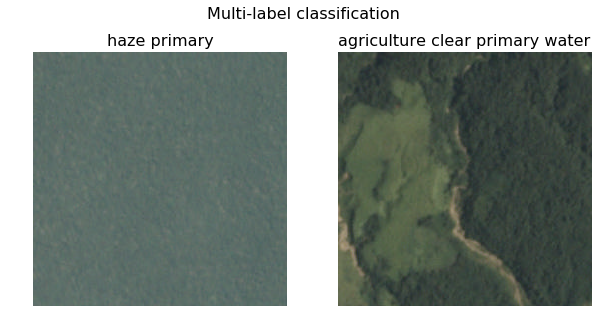

In [9]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

In multi-label classification each sample can belong to one or more clases. In the previous example, the first images belongs to two clases: *haze* and *primary*. The second image belongs to four clases: *agriculture*, *clear*, *primary* and  *water*.

## Multi-label models for Planet dataset

In [10]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [12]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [13]:
data = get_data(256)

In [14]:
x,y = next(iter(data.val_dl))

In [15]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [16]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

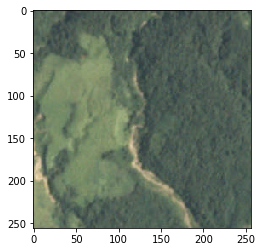

In [17]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [18]:
sz=64

In [19]:
data = get_data(sz)

In [20]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [21]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.221271   0.299573   0.788758  



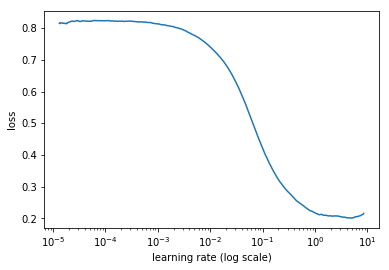

In [22]:
lrf=learn.lr_find()
learn.sched.plot()

In [23]:
lr = 0.2

In [24]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.14819    0.134486   0.883341  
    1      0.140923   0.129592   0.88613                     
    2      0.138489   0.127131   0.889981                    
    3      0.140953   0.127799   0.887525                    
    4      0.134964   0.124563   0.89192                     
    5      0.1313     0.123164   0.893663                    
    6      0.129789   0.123043   0.893083                    



[0.12304281, 0.893083331097186]

In [ ]:
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.120346   0.10945    0.907284  
    1      0.114335   0.105574   0.909322                    
    2      0.109371   0.101505   0.915457                    
 52%|█████▏    | 265/506 [00:43<00:39,  6.08it/s, loss=0.113]

In [ ]:
learn.save(f'{sz}')

In [ ]:
learn.sched.plot_loss()

In [ ]:
sz=128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
sz=256

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

In [ ]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [ ]:
f2(preds,y)

### End